# Practical Approaches to Optimizng Budget in Marketing Mix Modeling

Slava Kisilevich
kisilevich.slava@gmail.com

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from plotnine import *


#import plotly.io as pio
#pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

In [3]:
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [4]:
from prophet import Prophet

In [5]:
import optuna as opt

In [6]:
from functools import partial
from scipy import optimize

## Helper Functions

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
class AdstockGeometric(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.5):
        self.alpha = alpha
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray):
        x_decayed = np.zeros_like(X)
        x_decayed[0] = X[0]
        
        for xi in range(1, len(x_decayed)):
            x_decayed[xi] = X[xi] + self.alpha * x_decayed[xi - 1]
        return x_decayed
    
    
class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, slope_s, half_saturation_k):
        self.slope_s = slope_s
        self.half_saturation_k = half_saturation_k
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X: np.ndarray, x_point = None):
        
        self.half_saturation_k_transformed  = self.half_saturation_k * (np.max(X) - np.min(X)) + np.min(X)
        
        if x_point is None:
            return (1 + self.half_saturation_k_transformed**self.slope_s / X**self.slope_s)**-1
        
        #calculate y at x_point
        return (1 + self.half_saturation_k_transformed**self.slope_s / x_point**self.slope_s)**-1
            

## Data

In [9]:
data = pd.read_csv("./data/data_raw_2015-11-23__2019-11-11.csv", parse_dates = ["DATE"])
data.columns = [c.lower() if c in ["DATE"] else c for c in data.columns]
data

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000


In [10]:
holidays = pd.read_csv("./data/prophet_holidays_daily.csv", parse_dates = ["ds"])
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_de = holidays_weekly.query("(country == 'DE')").copy()
holidays_weekly_de

,ds,holiday,country,year
12,1994-12-26,Neujahr,DE,1995
183,1995-04-10,Karfreitag,DE,1995
222,1995-04-17,Ostermontag,DE,1995
270,1995-05-01,Erster Mai,DE,1995
346,1995-05-22,Christi Himmelfahrt,DE,1995
...,...,...,...,...
35445,2044-05-23,Christi Himmelfahrt,DE,2044
35481,2044-06-06,Pfingstmontag,DE,2044
35646,2044-10-03,Tag der Deutschen Einheit,DE,2044
35781,2044-12-19,Erster Weihnachtstag,DE,2044


In [11]:
prophet_data = data.rename(columns = {'revenue': 'y', 'date': 'ds'})
#add categorical into prophet
prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
prophet_data

,ds,y,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter,events_event2,events_na
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,na,19401.65385,0,1
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,na,14791.00000,0,1
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,na,14544.00000,0,1
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,na,2800.00000,0,1
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,na,15478.00000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,2019-10-14,2456240.00000,0.00000,60433,153723.66667,0.00000,152840.32341,112100,7612762,0.00000,na,28157.00000,0,1
204,2019-10-21,2182825.00000,154917.60000,0,0.00000,56881962.23521,103680.04782,103700,6701667,133624.57552,na,10644.00000,0,1
205,2019-10-28,2377706.66667,21982.50000,14094,17476.00000,0.00000,138387.70414,114700,7688920,0.00000,na,9597.00000,0,1
206,2019-11-04,2732825.00000,22453.00000,0,24051.33333,0.00000,151707.99046,134100,8815710,0.00000,na,90189.00000,0,1


In [12]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_de)
prophet.add_regressor(name = "events_event2")
prophet.add_regressor(name = "events_na")

In [13]:
prophet.fit(prophet_data[["ds", "y", "events_event2", "events_na"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y", "events_event2", "events_na"]])

20:41:03 - cmdstanpy - INFO - Chain [1] start processing
20:41:04 - cmdstanpy - INFO - Chain [1] done processing


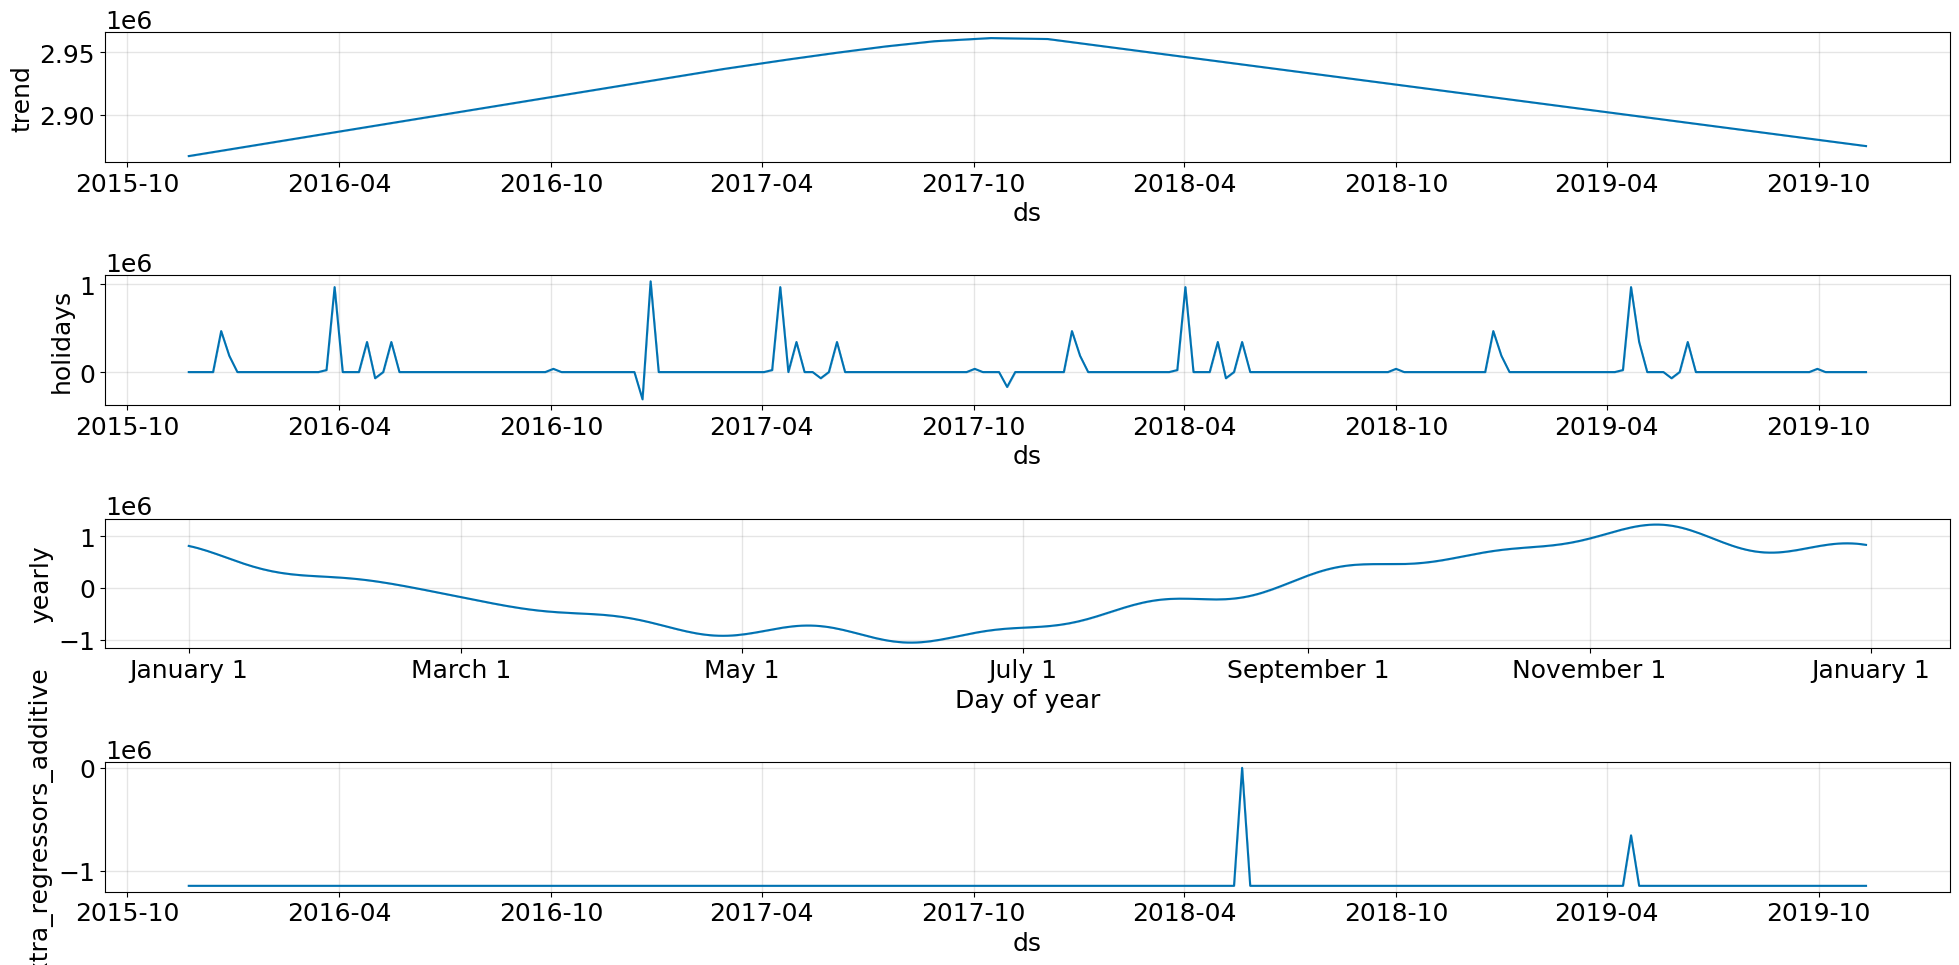

In [14]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [15]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]
final_data["events"] = (events_numeric - np.min(events_numeric)).values

In [16]:
data = final_data.copy()

## Modeling

In [17]:
def optuna_trial(trial, 
                 data:pd.DataFrame, 
                 target, 
                 features, 
                 adstock_features, 
                 adstock_features_params, 
                 hill_slopes_params, 
                 hill_half_saturations_params, 
                 tscv):
    
    data_temp = data.copy()
    adstock_alphas = {}
    hill_slopes = {}
    hill_half_saturations = {}
    
    for feature in adstock_features:
        adstock_param = f"{feature}_adstock"
        min_, max_ = adstock_features_params[adstock_param]
        adstock_alpha = trial.suggest_float(f"adstock_alpha_{feature}", min_, max_)
        adstock_alphas[feature] = adstock_alpha
        
        hill_slope_param = f"{feature}_hill_slope"
        min_, max_ = hill_slopes_params[hill_slope_param]
        hill_slope = trial.suggest_float(f"hill_slope_{feature}", min_, max_)
        hill_slopes[feature] = hill_slope
        
        hill_half_saturation_param = f"{feature}_hill_half_saturation"
        min_, max_ = hill_half_saturations_params[hill_half_saturation_param]
        hill_half_saturation = trial.suggest_float(f"hill_half_saturation_{feature}", min_, max_)
        hill_half_saturations[feature] = hill_half_saturation
        
        
        #adstock transformation
        x_feature = data[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        #hill saturation transformation
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_temp[feature] = temp_hill_saturation
        
        
    #Ridge parameters
    ridge_alpha = trial.suggest_float("ridge_alpha", 0.01, 10000)
    scores = []
    
    #cross validation
    for train_index, test_index in tscv.split(data_temp):
        x_train = data_temp.iloc[train_index][features]
        y_train =  data_temp[target].values[train_index]
        
        x_test = data_temp.iloc[test_index][features]
        y_test = data_temp[target].values[test_index]
        
        #params of Ridge Regression
        params = {"alpha": ridge_alpha}
        
        ridge = linear_model.Ridge(alpha = ridge_alpha, random_state=0)
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(x_test)
        
        rmse = mean_squared_error(y_true = y_test, y_pred = prediction, squared = False)
        scores.append(rmse)
        
        
    trial.set_user_attr("scores", scores)
    
    trial.set_user_attr("params", params)
    trial.set_user_attr("adstock_alphas", adstock_alphas)
    trial.set_user_attr("hill_slopes", hill_slopes)
    trial.set_user_attr("hill_half_saturations", hill_half_saturations)
    
    
    #average of all scores    
    return np.mean(scores)

In [18]:
def optuna_optimize(trials, 
                    data: pd.DataFrame, 
                    target, 
                    features, 
                    adstock_features, 
                    adstock_features_params, 
                    hill_slopes_params, 
                    hill_half_saturations_params, 
                    tscv, 
                    seed = 42):
    print(f"data size: {len(data)}")
    
    print(f"adstock features: {adstock_features}")
    print(f"features: {features}")

    opt.logging.set_verbosity(opt.logging.WARNING) 
    
    
    study_mmm = opt.create_study(direction='minimize', sampler = opt.samplers.TPESampler(seed=seed))  
        
    optimization_function = partial(optuna_trial, 
                                    data = data, 
                                    target = target, 
                                    features = features, 
                                    adstock_features = adstock_features, 
                                    adstock_features_params = adstock_features_params, 
                                    hill_slopes_params = hill_slopes_params, 
                                    hill_half_saturations_params = hill_half_saturations_params, 
                                    tscv = tscv, 
                                    )
    
    
    study_mmm.optimize(optimization_function, n_trials = trials, show_progress_bar = True)
    
    return study_mmm

## Features and parameters

In [ ]:
target = "revenue"
media_channels = ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"]
organic_channels = ["newsletter"]
control_features = ["trend", "season", "holiday", "competitor_sales_B", "events"]
features = control_features + media_channels + organic_channels


tscv = TimeSeriesSplit(n_splits=2, test_size = 5)

adstock_features_params = {}
adstock_features_params["tv_S_adstock"] = (0.3, 0.8)
adstock_features_params["ooh_S_adstock"] = (0.1, 0.4)
adstock_features_params["print_S_adstock"] = (0.1, 0.4)
adstock_features_params["facebook_S_adstock"] = (0.1, 0.4)
adstock_features_params["search_S_adstock"] = (0.1, 0.3)
adstock_features_params["newsletter_adstock"] = (0.1, 0.4)

hill_slopes_params = {}
hill_slopes_params["tv_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["ooh_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["print_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["facebook_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["search_S_hill_slope"] = (0.1, 5.0)
hill_slopes_params["newsletter_hill_slope"] = (0.1, 5.0)

hill_half_saturations_params = {}
hill_half_saturations_params["tv_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["ooh_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["print_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["facebook_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["search_S_hill_half_saturation"] = (0.1, 1.0)
hill_half_saturations_params["newsletter_hill_half_saturation"] = (0.1, 1.0)

OPTUNA_TRIALS = 2000
experiment = optuna_optimize(trials = OPTUNA_TRIALS, 
                             data = data, 
                             target = target, 
                             features = features, 
                             adstock_features = media_channels + organic_channels, 
                             adstock_features_params = adstock_features_params, 
                             hill_slopes_params = hill_slopes_params,
                             hill_half_saturations_params = hill_half_saturations_params,
                             tscv = tscv)

In [128]:
np.mean(experiment.best_trial.user_attrs["scores"])

27130.03179242643

In [129]:
experiment.best_trial.user_attrs["scores"]

[27769.743539219286, 26490.32004563358]

In [130]:
#ridge regression param
experiment.best_trial.user_attrs["params"]

{'alpha': 2.0210686319461577}

In [131]:
experiment.best_trial.user_attrs["adstock_alphas"]

{'tv_S': 0.39987207669559194,
 'ooh_S': 0.3182898770747448,
 'print_S': 0.36463964294292667,
 'facebook_S': 0.024323741217620206,
 'search_S': 0.1775216484828553,
 'newsletter': 0.26518091257501725}

In [132]:
experiment.best_trial.user_attrs["hill_slopes"]

{'tv_S': 4.004683805756836,
 'ooh_S': 2.5974871525076266,
 'print_S': 1.2894574221490176,
 'facebook_S': 1.9380296999955513,
 'search_S': 3.150629481608637,
 'newsletter': 3.745250968758368}

In [133]:
experiment.best_trial.user_attrs["hill_half_saturations"]

{'tv_S': 0.161494474860242,
 'ooh_S': 0.6432430638071762,
 'print_S': 0.7249714745367867,
 'facebook_S': 0.7012478292834047,
 'search_S': 0.45062885101478806,
 'newsletter': 0.3314449407058461}

## Model Refit

In [134]:
def model_refit(data, 
                target, 
                features, 
                media_channels, 
                organic_channels, 
                model_params, 
                adstock_params, 
                hill_slopes_params,
                hill_half_saturations_params,
                start_index, 
                end_index):
    data_refit = data.copy()

    best_params = model_params

    adstock_alphas = adstock_params

    
    #apply adstock transformation
    
    temporal_features = [feature if feature not in media_channels and feature not in organic_channels else f"{feature}_hill" for feature in features]
    
    for feature in media_channels + organic_channels:
        adstock_alpha = adstock_alphas[feature]
        print(f"applying geometric adstock transformation on {feature} with alpha {adstock_alpha:0.3}") 

        #adstock transformation
        x_feature = data_refit[feature].values.reshape(-1, 1)
        temp_adstock = AdstockGeometric(alpha = adstock_alpha).fit_transform(x_feature)
        
        hill_slope = hill_slopes_params[feature]
        hill_half_saturation = hill_half_saturations_params[feature]
        print(f"applying saturation hill transformation on {feature} with saturation slope {hill_slope:0.3} and half saturation {hill_half_saturation:0.3}")
        
        temp_hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(temp_adstock)
        data_refit[f"{feature}_adstock"] = temp_adstock
        data_refit[f"{feature}_hill"] = temp_hill_saturation

    #build the final model on the data until the end analysis index
    x_input = data_refit.iloc[0:end_index][temporal_features].copy()
    y_true_all = data[target].values[0:end_index]

    #build ridge using the best parameters
    model = linear_model.Ridge(random_state=0, **best_params)
    model.fit(x_input, y_true_all) 


    #concentrate on the analysis interval
    y_true_interval = y_true_all[start_index:end_index]
    #transformed data
    x_input_interval_transformed = x_input.iloc[start_index:end_index]

    #revenue prediction for the analysis interval
    print(f"predicting {len(x_input_interval_transformed)} instances")
    prediction = model.predict(x_input_interval_transformed)

    #non transformed data set for the analysis interval 
    x_input_interval_nontransformed = data.iloc[start_index:end_index]

    
    return {
            'x_input_interval_nontransformed': x_input_interval_nontransformed, 
            'x_input_interval_transformed' : x_input_interval_transformed,
            'prediction_interval': prediction, 
            'y_true_interval': y_true_interval,
            "model": model,
            "model_train_data": x_input,
            "model_data": data_refit, 
            "model_features": temporal_features, 
            "features": features
           }
    

In [135]:
best_params = experiment.best_trial.user_attrs["params"]
adstock_params_best = experiment.best_trial.user_attrs["adstock_alphas"]
hill_slopes_params_best = experiment.best_trial.user_attrs["hill_slopes"]
hill_half_saturations_params_best = experiment.best_trial.user_attrs["hill_half_saturations"]

result = model_refit(data = data, 
                     target = target,
                     features = features, 
                     media_channels = media_channels, 
                     organic_channels = organic_channels, 
                     model_params = best_params, 
                     adstock_params = adstock_params_best, 
                     hill_slopes_params=hill_slopes_params_best,
                     hill_half_saturations_params=hill_half_saturations_params_best,
                     start_index = 0, 
                     end_index = data.shape[0])

applying geometric adstock transformation on tv_S with alpha 0.4
applying saturation hill transformation on tv_S with saturation slope 4.0 and half saturation 0.161
applying geometric adstock transformation on ooh_S with alpha 0.318
applying saturation hill transformation on ooh_S with saturation slope 2.6 and half saturation 0.643
applying geometric adstock transformation on print_S with alpha 0.365
applying saturation hill transformation on print_S with saturation slope 1.29 and half saturation 0.725
applying geometric adstock transformation on facebook_S with alpha 0.0243
applying saturation hill transformation on facebook_S with saturation slope 1.94 and half saturation 0.701
applying geometric adstock transformation on search_S with alpha 0.178
applying saturation hill transformation on search_S with saturation slope 3.15 and half saturation 0.451
applying geometric adstock transformation on newsletter with alpha 0.265
applying saturation hill transformation on newsletter with sat

C:\Users\kisilevich\AppData\Local\Temp\ipykernel_29812\3344362703.py:31: RuntimeWarning:

divide by zero encountered in divide

C:\Users\kisilevich\AppData\Local\Temp\ipykernel_29812\3344362703.py:31: RuntimeWarning:

divide by zero encountered in divide



In [136]:
#different parameters
result.keys()

dict_keys(['x_input_interval_nontransformed', 'x_input_interval_transformed', 'prediction_interval', 'y_true_interval', 'model', 'model_train_data', 'model_data', 'model_features', 'features'])

In [137]:
#features used during modeling
result["model_features"]

['trend',
 'season',
 'holiday',
 'competitor_sales_B',
 'events',
 'tv_S_hill',
 'ooh_S_hill',
 'print_S_hill',
 'facebook_S_hill',
 'search_S_hill',
 'newsletter_hill']

In [138]:
result["model"].intercept_

-2007595.2705572727

In [139]:
#save feature coefficients 
feature_coefficients = {}
for feature, model_feature, coef in zip(result["features"], result["model_features"], result["model"].coef_):
    feature_coefficients[feature] = coef
    print(f"feature: {feature} -> coefficient {coef}")

feature: trend -> coefficient 0.7623648130973445
feature: season -> coefficient 0.1387758369358602
feature: holiday -> coefficient 1.0259885579481447
feature: competitor_sales_B -> coefficient 0.2606854569386566
feature: events -> coefficient 1.0875828443592699
feature: tv_S -> coefficient 183418.33519865316
feature: ooh_S -> coefficient 101271.2094498436
feature: print_S -> coefficient 168975.1133374742
feature: facebook_S -> coefficient 52889.50504442561
feature: search_S -> coefficient 20734.524144266117
feature: newsletter -> coefficient 49588.72055701861


In [140]:
#data used for modeling
result["model_data"].head()

,date,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,...,ooh_S_adstock,ooh_S_hill,print_S_adstock,print_S_hill,facebook_S_adstock,facebook_S_hill,search_S_adstock,search_S_hill,newsletter_adstock,newsletter_hill
0,2015-11-23,2754371.66667,167687.60000,0,95463.66667,72903852.71259,0.00000,0,8125009,228213.98744,...,0,0.00000,95463.66667,0.29600,228213.98744,0.33641,0,0.00000,19401.65385,0.05821
1,2015-11-30,2584276.66667,214600.90000,0,0.00000,16581099.54533,29511.71546,31000,7901549,34258.57351,...,0,0.00000,34809.83733,0.10273,39809.59148,0.01690,31000,0.06726,19935.94827,0.06404
2,2015-12-07,2547386.66667,0.00000,248022,3404.00000,49954773.67047,36132.35896,28400,8300197,127691.26133,...,248022,0.08927,16097.04665,0.04063,128659.57954,0.14307,33903,0.08726,19830.63296,0.06286
3,2015-12-14,2875220.00000,625877.30000,0,132600.00000,31649297.02879,36804.21096,31900,8122883,84014.72031,...,78942,0.00499,138469.62134,0.40447,87144.20262,0.07276,37918,0.11974,8058.70534,0.00230
4,2015-12-21,2215953.33333,0.00000,520005,0.00000,8802269.47875,28401.74407,27100,7105985,20687.47816,...,545131,0.43118,50491.51329,0.15607,22807.15119,0.00581,33831,0.08673,17615.01484,0.04127


In [141]:
mape_final= mean_absolute_percentage_error(result["y_true_interval"], result["prediction_interval"])
print(f"MAPE: {mape_final:0.3}")

MAPE: 0.0492


In [216]:
def plot_spend_response_curve(channel, spend_response_df, average_spend = 0, average_response = 0, optimized_spend = None, optimized_response = None, figure_size = (15, 6)):
    average_spend_response_df = pd.DataFrame({
                                              'average_spend': [average_spend], 
                                              'average_response': [average_response]
                                             })
    plt = ggplot(spend_response_df, aes("spend", "response")) + geom_line()\
    + xlab("Spend (with adstock effect)") + ylab("Response")\
    + geom_point(data = average_spend_response_df, mapping = aes(x = "average_spend", y = "average_response"), size = 3, color = "blue")\
    + geom_vline(data = average_spend_response_df, mapping = aes(xintercept = "average_spend"), linetype='dotted', alpha = 0.5)\
    + geom_hline(data = average_spend_response_df, mapping = aes(yintercept = "average_response"), linetype='dotted', alpha = 0.5)\
     + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.3,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
            ) 
    
    

    if optimized_spend is not None and optimized_response is not None:
        optimized_spend_response_df = pd.DataFrame({'optimized_spend': [optimized_spend], 'optimized_response': [optimized_response]})
        plt = plt + geom_point(data = optimized_spend_response_df, mapping = aes(x = "optimized_spend", y = "optimized_response"), size = 4, color = "green")\
            + geom_vline(data = optimized_spend_response_df, mapping = aes(xintercept = "optimized_spend"), linetype='dotted', alpha = 0.5, color = "green")\
            + geom_hline(data = optimized_spend_response_df, mapping = aes(yintercept = "optimized_response"), linetype='dotted', alpha = 0.5, color = "green")\
              + ggtitle(f"{channel}: Response curve, mean and optimized spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:0.3f}\nOptimized Spend: {optimized_spend:0.3f}\nOptimized Response: {optimized_response:0.3f}")
    else:
        plt = plt + ggtitle(f"{channel}: Response curve and mean spend\nAverage Spend: {average_spend}\nAverage Response: {average_response:0.3f}")
        
    return plt


def plot_multiple_spend_response_curves(spend_response_df, figure_size = (15, 6)):
    plt = ggplot(spend_response_df, aes("spend", "response", color = "media_channel")) + geom_line()\
        + xlab("Spend (with adstock effect)") + ggtitle("Response curves")\
        + theme(figure_size = figure_size,
                        legend_direction='vertical', 
                        legend_position= "right",
                        legend_box_spacing=0.6,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
            ) 
    
    return plt

In [143]:
feature_coefficients

{'trend': 0.7623648130973445,
 'season': 0.1387758369358602,
 'holiday': 1.0259885579481447,
 'competitor_sales_B': 0.2606854569386566,
 'events': 1.0875828443592699,
 'tv_S': 183418.33519865316,
 'ooh_S': 101271.2094498436,
 'print_S': 168975.1133374742,
 'facebook_S': 52889.50504442561,
 'search_S': 20734.524144266117,
 'newsletter': 49588.72055701861}

tv_S
	tv_S: adstock: 0.39987207669559194
	tv_S: saturation slope: 4.004683805756836
	tv_S: half saturation k: 0.161494474860242
	tv_S: coefficient: 183418.33519865316
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average non zero spending: 18088.498505909305


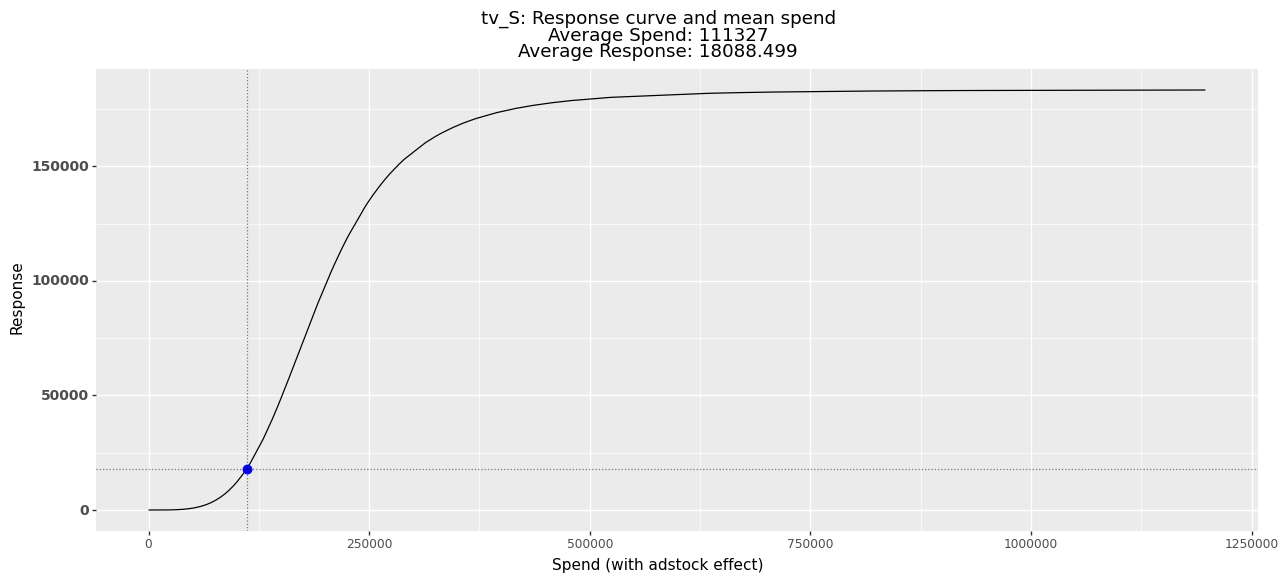


ooh_S
	ooh_S: adstock: 0.3182898770747448
	ooh_S: saturation slope: 2.5974871525076266
	ooh_S: half saturation k: 0.6432430638071762
	ooh_S: coefficient: 101271.2094498436
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average non zero spending: 540.1972219634779


C:\Users\kisilevich\AppData\Local\Temp\ipykernel_29812\3344362703.py:31: RuntimeWarning:

divide by zero encountered in divide



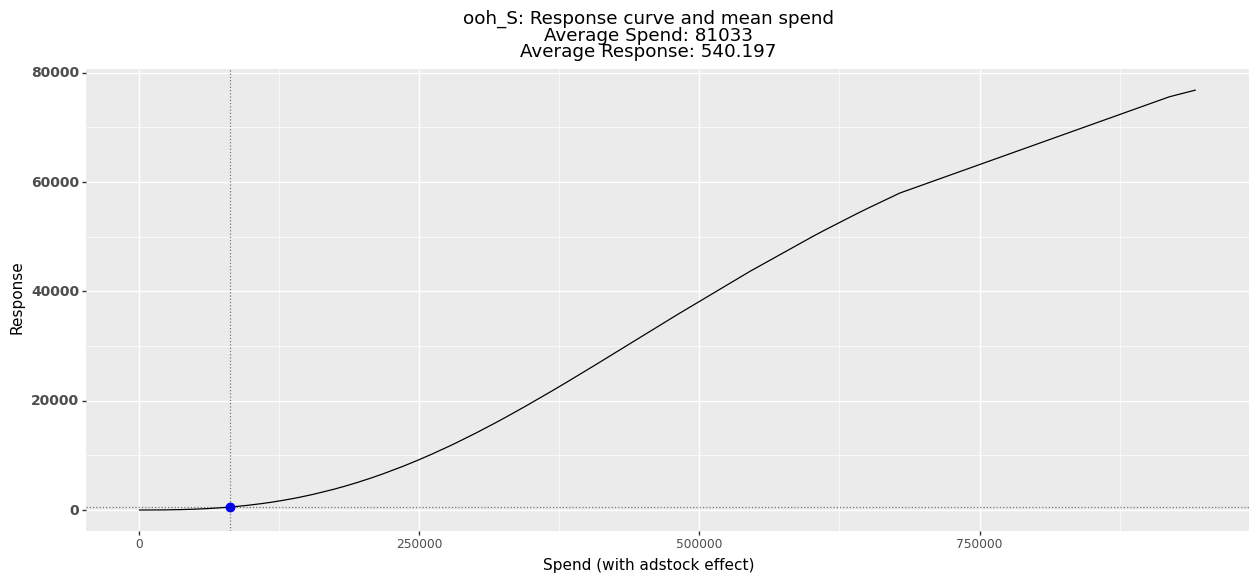


print_S
	print_S: adstock: 0.36463964294292667
	print_S: saturation slope: 1.2894574221490176
	print_S: half saturation k: 0.7249714745367867
	print_S: coefficient: 168975.1133374742
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.333333333
	average response corresponding to the average non zero spending: 13427.427056962197


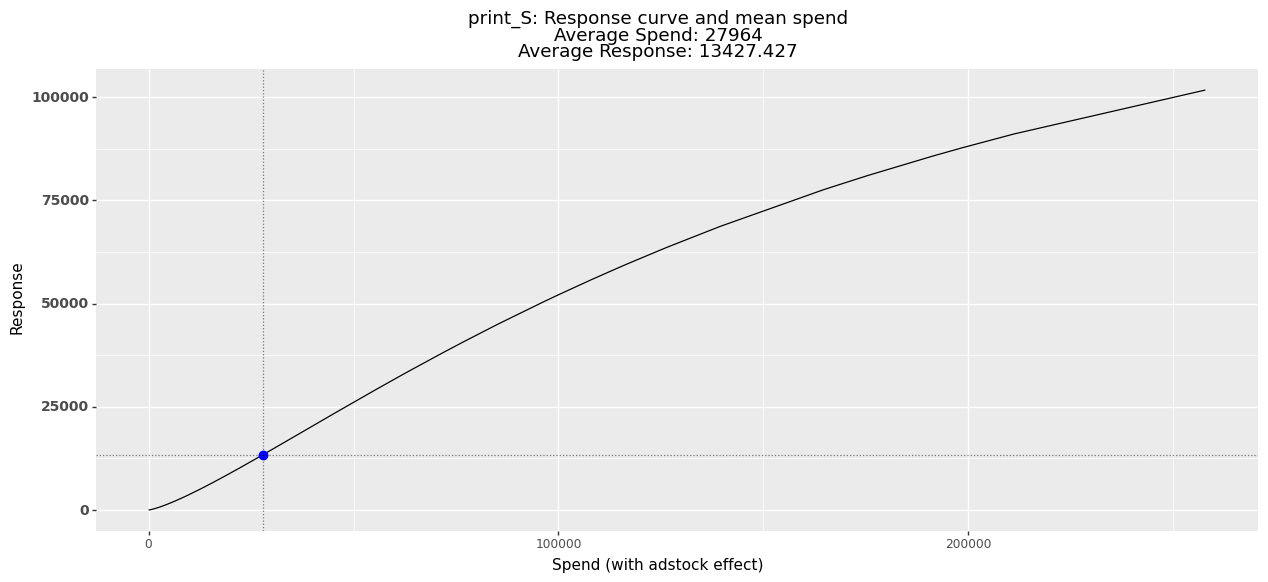


facebook_S
	facebook_S: adstock: 0.024323741217620206
	facebook_S: saturation slope: 1.9380296999955513
	facebook_S: half saturation k: 0.7012478292834047
	facebook_S: coefficient: 52889.50504442561
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.742240227
	average response corresponding to the average non zero spending: 2210.7108882597504


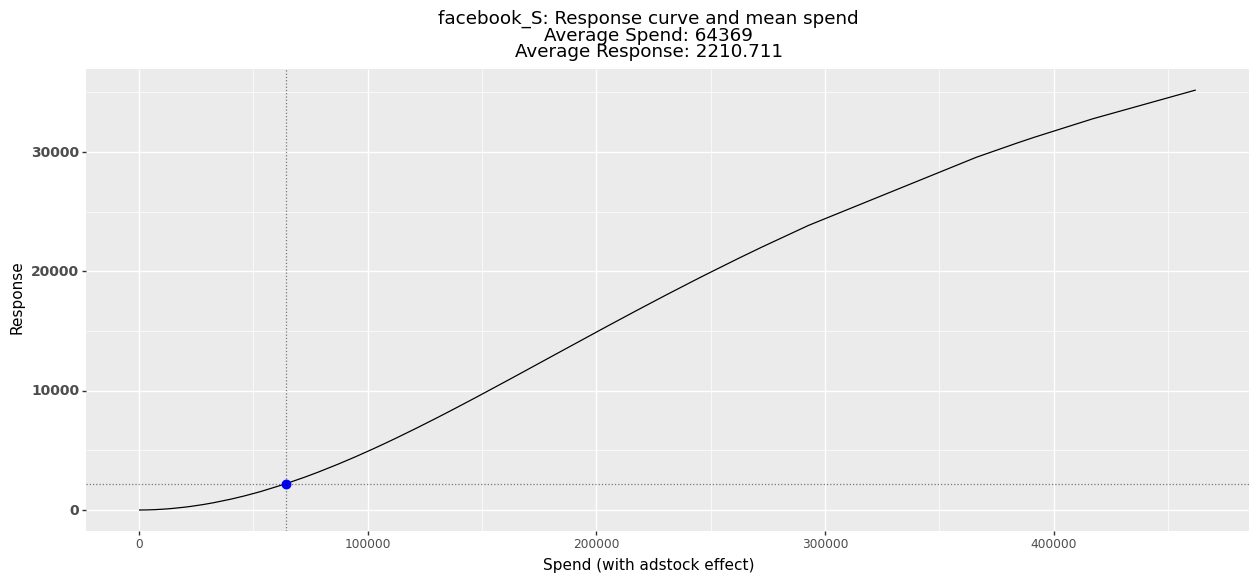


search_S
	search_S: adstock: 0.1775216484828553
	search_S: saturation slope: 3.150629481608637
	search_S: half saturation k: 0.45062885101478806
	search_S: coefficient: 20734.524144266117
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average non zero spending: 3782.1482118133704


C:\Users\kisilevich\AppData\Local\Temp\ipykernel_29812\3344362703.py:31: RuntimeWarning:

divide by zero encountered in divide



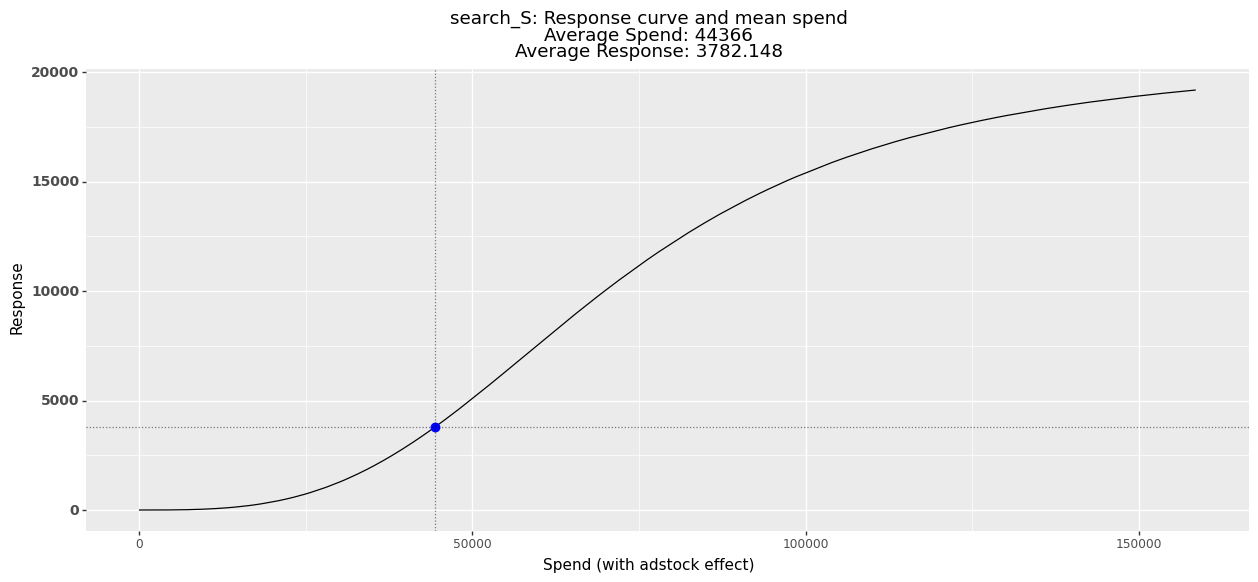

In [204]:
#dataframe for budget allocation
media_spend_response_data = []

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for media_channel in media_channels:
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_spending)
    print(f"\taverage response corresponding to the average non zero spending: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response, "media_channel": media_channel})

    media_spend_response_data.append(spend_response_temp_df)
    
    plot = plot_spend_response_curve(media_channel, spend_response_temp_df, average_spend = average_spending, average_response = average_response)
    print(plot)
    

media_spend_response_data = pd.concat(media_spend_response_data)

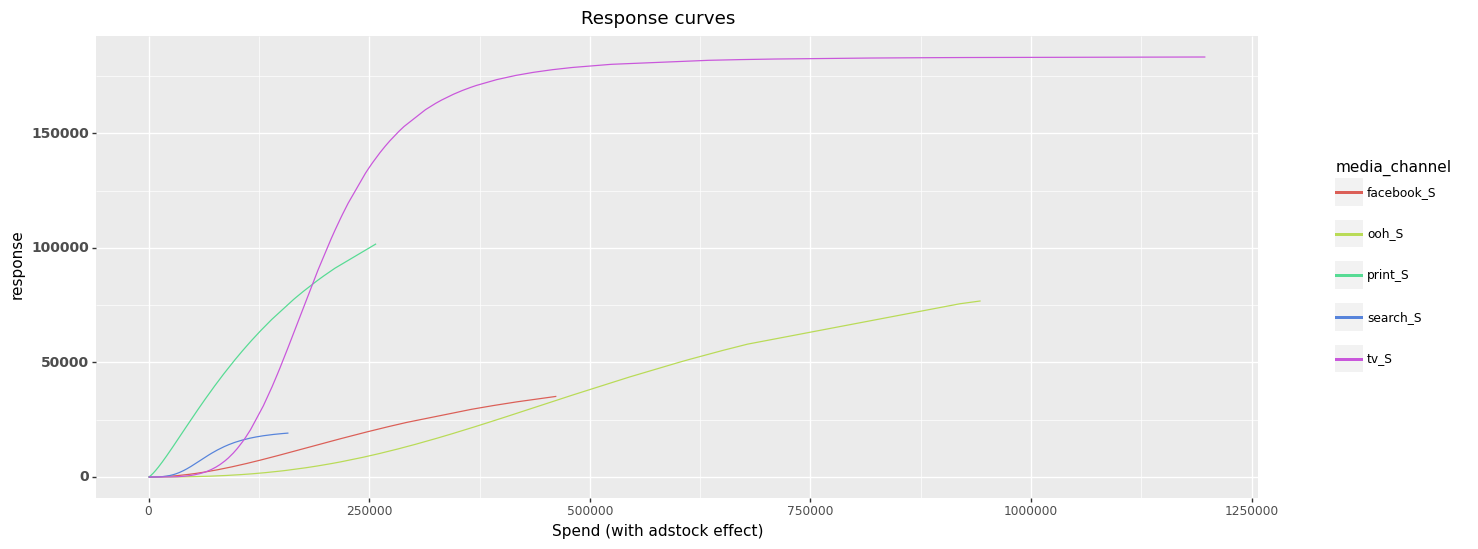

<ggplot: (129976568414)>

In [217]:
plot_multiple_spend_response_curves(media_spend_response_data)

## Budget Optimization using Saturation Curves

In [315]:
optimization_percentage = 0.2


media_channel_average_spend = result["model_data"][media_channels].mean(axis=0).values

lower_bound = media_channel_average_spend * np.ones(len(media_channels))*(1-optimization_percentage)
upper_bound = media_channel_average_spend * np.ones(len(media_channels))*(1+optimization_percentage)

boundaries = optimize.Bounds(lb=lower_bound, ub=upper_bound)

print(boundaries.lb.shape)
print(boundaries.lb)
print(media_channel_average_spend)
print(boundaries.ub)

print(f"total budget: {np.sum(media_channel_average_spend)}")

(5,)
[       89062.147        64826.912        22371.794        51495.788        35493.077]
[      111327.684        81033.639        27964.742        64369.735        44366.346]
[      133593.221        97240.367        33557.690        77243.682        53239.615]
total budget: 329062.1464875821


In [332]:
def budget_constraint(media_spend, budget):  
  return np.sum(media_spend) - budget


def saturation_objective_function(coefficients, 
                                  hill_slopes, 
                                  hill_half_saturations, 
                                  media_min_max_dictionary, 
                                  media_inputs):
    
    responses = []
    for i in range(len(coefficients)):
        coef = coefficients[i]
        hill_slope = hill_slopes[i]
        hill_half_saturation = hill_half_saturations[i]
        
        min_max = np.array(media_min_max_dictionary[i])
        media_input = media_inputs[i]
        
        hill_saturation = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).transform(X = min_max, x_point = media_input)
        response = coef * hill_saturation
        responses.append(response)
        
    responses = np.array(responses)
    responses_total = np.sum(responses)
    return -responses_total

In [333]:
media_coefficients = [feature_coefficients[media_channel] for media_channel in media_channels]
media_hill_slopes = [hill_slopes_params_best[media_channel] for media_channel in media_channels]
media_hill_half_saturations = [hill_half_saturations_params_best[media_channel] for media_channel in media_channels]

print(f"media coefficients: {media_coefficients}")
print(f"media hill slopes: {media_hill_slopes}")
print(f"media half saturations: {media_hill_half_saturations}")

#we have to pass min and max of each media channel for proper mapping for saturation hill
media_min_max = [(result["model_data"][f"{media_channel}_adstock"].min(),result["model_data"][f"{media_channel}_adstock"].max())  for media_channel in media_channels]
print(media_min_max)

media coefficients: [183418.33519865316, 101271.2094498436, 168975.1133374742, 52889.50504442561, 20734.524144266117]
media hill slopes: [4.004683805756836, 2.5974871525076266, 1.2894574221490176, 1.9380296999955513, 3.150629481608637]
media half saturations: [0.161494474860242, 0.6432430638071762, 0.7249714745367867, 0.7012478292834047, 0.45062885101478806]
[(55.96291574355453, 1197550.0613785875), (0, 942852), (0.6488027602078809, 257828.5407093836), (4.2290178036421534e-11, 462062.5078374995), (0, 158494)]


In [334]:
partial_saturation_objective_function = partial(saturation_objective_function, 
                                                media_coefficients, 
                                                media_hill_slopes, 
                                                media_hill_half_saturations, 
                                                media_min_max)


max_iterations = 100
solver_func_tolerance = 1.0e-10

solution = optimize.minimize(
      fun=partial_saturation_objective_function,
      x0=media_channel_average_spend,
      bounds=boundaries,
      method="SLSQP",
      jac="3-point",
      options={
          "maxiter": max_iterations,
          "disp": True,
          "ftol": solver_func_tolerance,
      },
      constraints={
          "type": "eq",
          "fun": budget_constraint,
          "args": (np.sum(media_channel_average_spend), )
      })


Optimization terminated successfully    (Exit mode 0)
            Current function value: -56391.257102409334
            Iterations: 32
            Function evaluations: 341
            Gradient evaluations: 31


In [335]:
print(f"initial average spend: {media_channel_average_spend}")
print(f"optimized average spend: {solution.x}")

initial average spend: [      111327.684        81033.639        27964.742        64369.735        44366.346]
optimized average spend: [      133593.221        64826.912        33557.690        51495.788        45588.536]


In [222]:
non_optimized_response = partial_saturation_objective_function(media_channel_average_spend) 
optimized_response = partial_saturation_objective_function(solution.x)

print(f"non-optimized response: {non_optimized_response}")
print(f"optimized response: {optimized_response}")

non-optimized response: -38049.93993379056
optimized response: -56391.257102409334


In [219]:
media_channel_average_spend.sum(), sum(solution.x)

(329062.1464875821, 329062.1464875821)

### Plot Optimized Budget

tv_S
	tv_S: adstock: 0.39987207669559194
	tv_S: saturation slope: 4.004683805756836
	tv_S: half saturation k: 0.161494474860242
	tv_S: coefficient: 183418.33519865316
	average spend: 111327, avergae non-zero spend: 251697, min spend: 0.0, max spend: 1185349.3
	average response corresponding to the average non zero spending: 18088.498505909305
	optimized spend: 133593.22
	optimized response: 33941.54


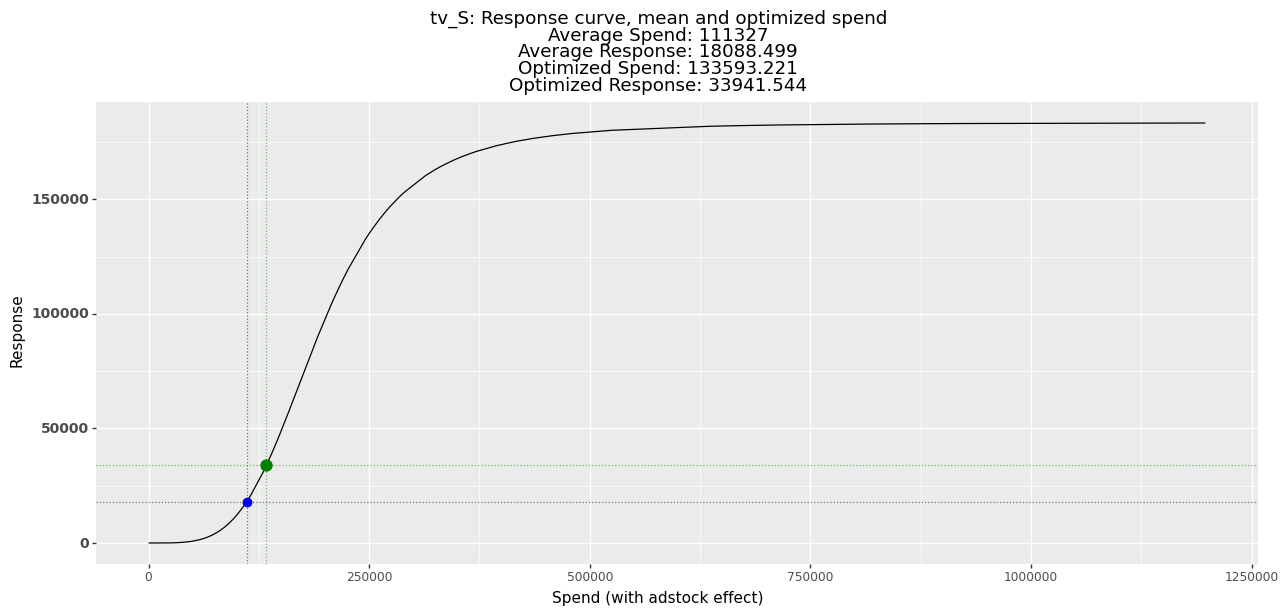


ooh_S
	ooh_S: adstock: 0.3182898770747448
	ooh_S: saturation slope: 2.5974871525076266
	ooh_S: half saturation k: 0.6432430638071762
	ooh_S: coefficient: 101271.2094498436
	average spend: 81033, avergae non-zero spend: 198294, min spend: 0, max spend: 938178
	average response corresponding to the average non zero spending: 540.1972219634779
	optimized spend: 64826.91
	optimized response: 303.29


C:\Users\kisilevich\AppData\Local\Temp\ipykernel_29812\3344362703.py:31: RuntimeWarning:

divide by zero encountered in divide



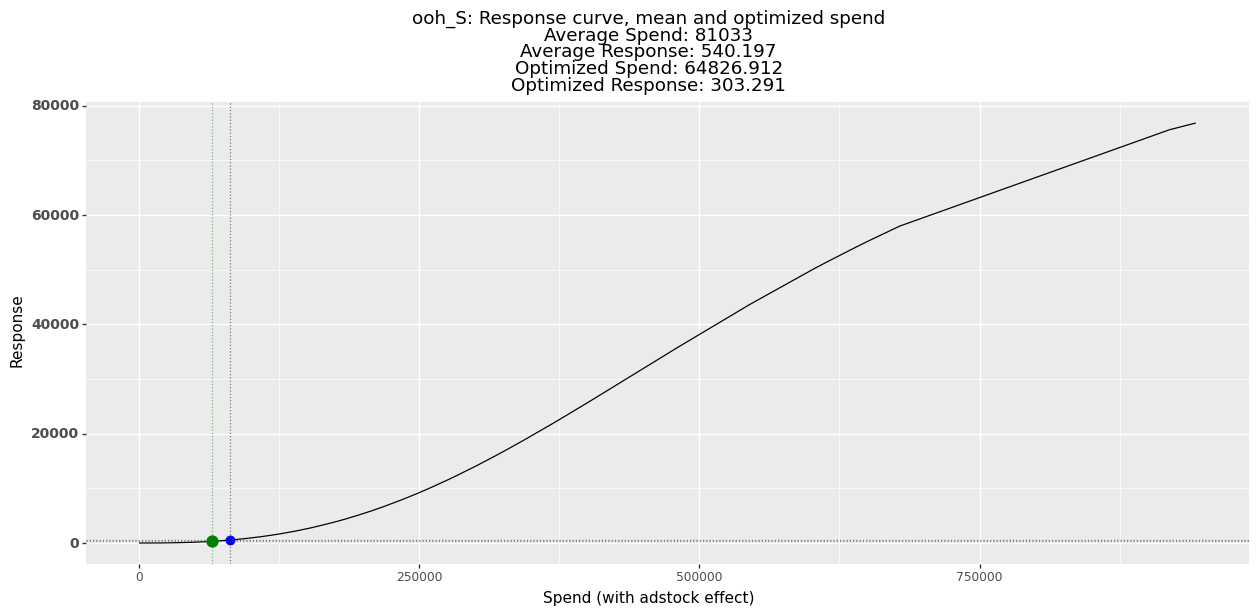


print_S
	print_S: adstock: 0.36463964294292667
	print_S: saturation slope: 1.2894574221490176
	print_S: half saturation k: 0.7249714745367867
	print_S: coefficient: 168975.1133374742
	average spend: 27964, avergae non-zero spend: 66858, min spend: 0.0, max spend: 239417.333333333
	average response corresponding to the average non zero spending: 13427.427056962197
	optimized spend: 33557.69
	optimized response: 16636.26


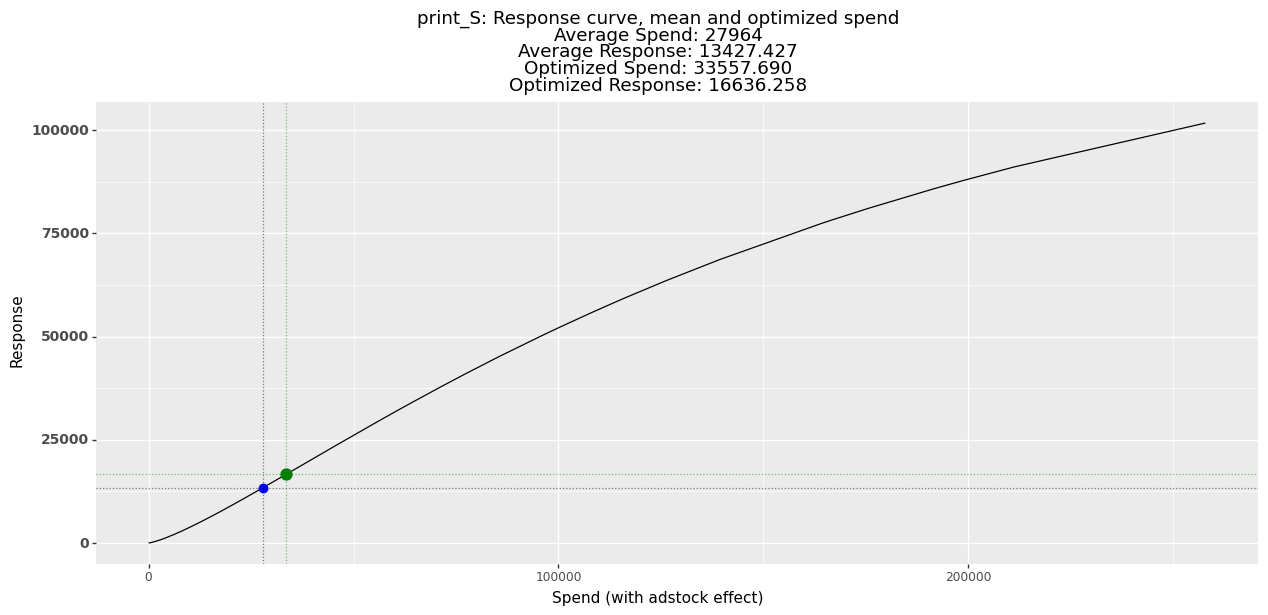


facebook_S
	facebook_S: adstock: 0.024323741217620206
	facebook_S: saturation slope: 1.9380296999955513
	facebook_S: half saturation k: 0.7012478292834047
	facebook_S: coefficient: 52889.50504442561
	average spend: 64369, avergae non-zero spend: 132563, min spend: 0.0, max spend: 462011.742240227
	average response corresponding to the average non zero spending: 2210.7108882597504
	optimized spend: 51495.79
	optimized response: 1455.95


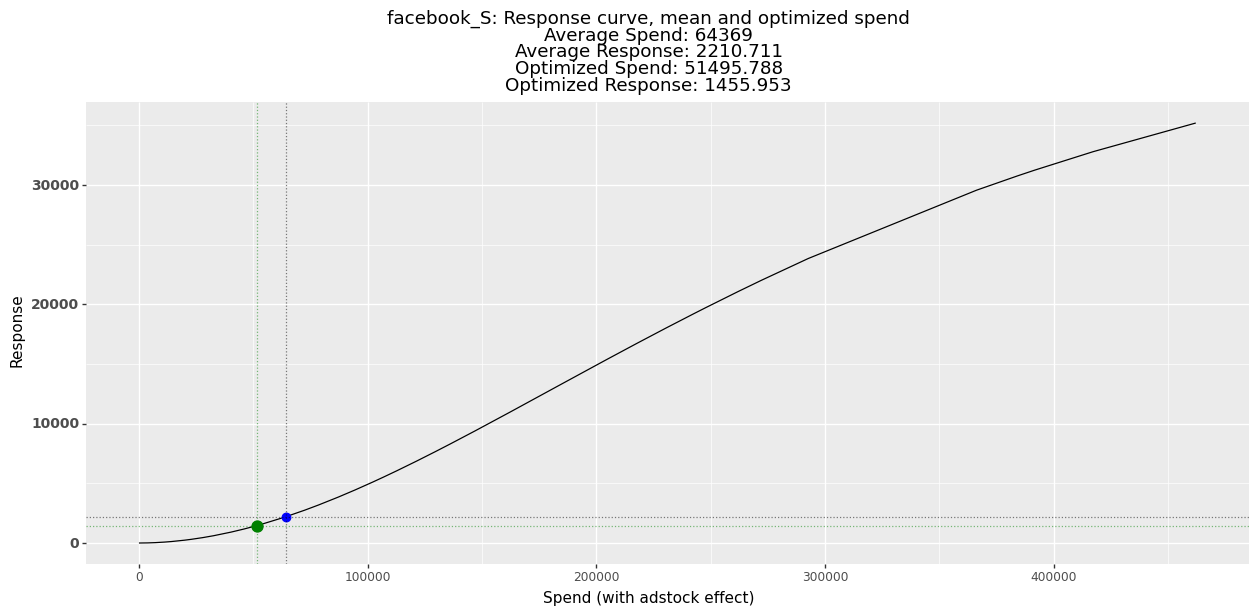


search_S
	search_S: adstock: 0.1775216484828553
	search_S: saturation slope: 3.150629481608637
	search_S: half saturation k: 0.45062885101478806
	search_S: coefficient: 20734.524144266117
	average spend: 44366, avergae non-zero spend: 52432, min spend: 0, max spend: 134100
	average response corresponding to the average non zero spending: 3782.1482118133704
	optimized spend: 45588.54
	optimized response: 4054.21


C:\Users\kisilevich\AppData\Local\Temp\ipykernel_29812\3344362703.py:31: RuntimeWarning:

divide by zero encountered in divide



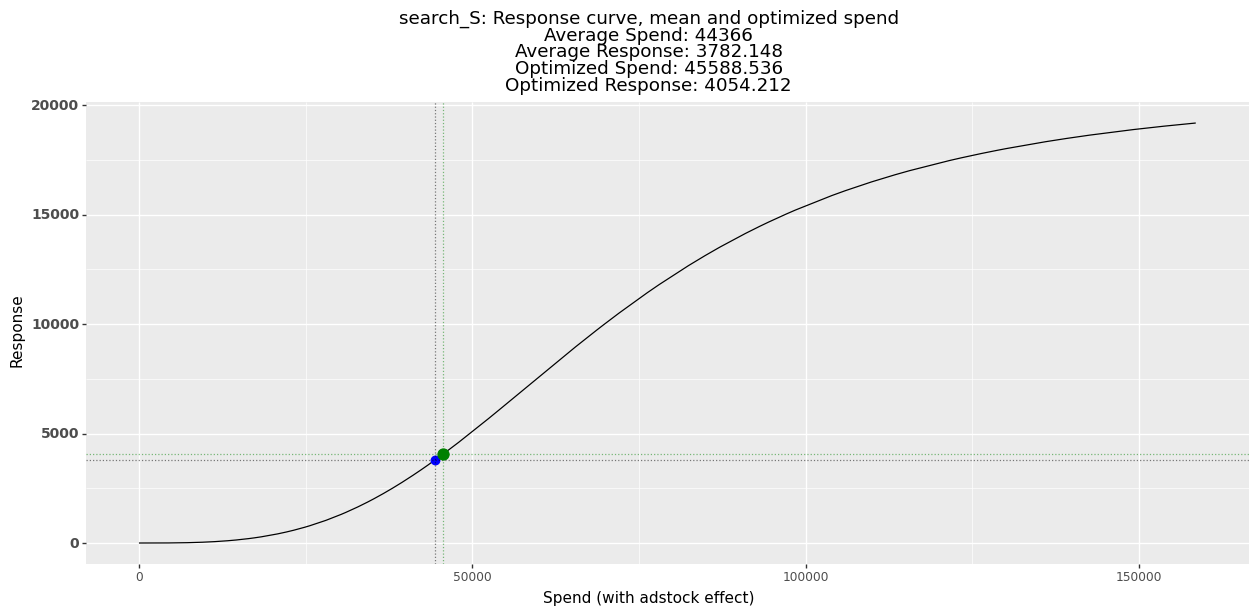

In [202]:
#dataframe for budget allocation
budget_allocation_input = pd.DataFrame()

#holds spend and response time series along with average spend/response for plotting spend-response curve
spend_response_curve_dict = {}

for i, media_channel in enumerate(media_channels):
    print(media_channel)
    
    adstock = adstock_params_best[media_channel]
    print(f"\t{media_channel}: adstock: {adstock}")

    hill_slope = hill_slopes_params_best[media_channel]
    hill_half_saturation = hill_half_saturations_params_best[media_channel]
    print(f"\t{media_channel}: saturation slope: {hill_slope}")
    print(f"\t{media_channel}: half saturation k: {hill_half_saturation}")

    coef = feature_coefficients[media_channel]
    print(f"\t{media_channel}: coefficient: {coef}")
    ######################################################

    #loc returns end index inclusive
    spendings = result["model_data"][media_channel].values
    average_nonzero_spending = int(spendings[spendings > 0].mean())
    average_spending = int(spendings.mean())
    print(f"\taverage spend: {average_spending}, avergae non-zero spend: {average_nonzero_spending}, min spend: {spendings.min()}, max spend: {spendings.max()}")

    spendings_adstocked = AdstockGeometric(alpha = adstock).fit_transform(spendings)
    
    #we have to use the same data that we used for training for proper mapping of the average spending
    average_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = average_spending)
    print(f"\taverage response corresponding to the average non zero spending: {average_response}")

    #numpy array returns end index exclusive
    spendings_saturated = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).fit_transform(spendings_adstocked)
    
    response = spendings_saturated * coef  

    spend_response_temp_df = pd.DataFrame({'spend': spendings_adstocked, 'response': response})
    
    #optimized
    optimized_spend = solution.x[i]
    optimized_response = coef * HillSaturation(slope_s=hill_slope, half_saturation_k=hill_half_saturation).transform(X = spendings_adstocked, x_point = optimized_spend)

    print(f"\toptimized spend: {optimized_spend:0.2f}")
    print(f"\toptimized response: {optimized_response:0.2f}")
    
    plot = plot_spend_response_curve(media_channel, 
                                     spend_response_temp_df, 
                                     average_spend = average_spending, 
                                     average_response = average_response, 
                                     optimized_response=optimized_response, 
                                     optimized_spend=optimized_spend)
    print(plot)

## Budget Optimization using Model

In [342]:
optimization_period = result["model_data"].shape[0]
print(f"optimization period: {optimization_period}")


optimization_percentage = 0.2


media_channel_average_spend = optimization_period * result["model_data"][media_channels].mean(axis=0).values

lower_bound = media_channel_average_spend * np.ones(len(media_channels))*(1-optimization_percentage)
upper_bound = media_channel_average_spend * np.ones(len(media_channels))*(1+optimization_percentage)

boundaries = optimize.Bounds(lb=lower_bound, ub=upper_bound)

print(boundaries.lb.shape)
print(boundaries.lb)
print(media_channel_average_spend)
print(boundaries.ub)

print(f"total budget: {np.sum(media_channel_average_spend)}")

optimization period: 208
(5,)
[    18524926.640     13483997.600      4653333.067     10711123.869      7382560.000]
[    23156158.300     16854997.000      5816666.333     13388904.836      9228200.000]
[    27787389.960     20225996.400      6979999.600     16066685.803     11073840.000]
total budget: 68444926.46941707


In [343]:
def model_based_objective_function(model, 
                                   optimization_period, 
                                   model_features, 
                                   additional_inputs, 
                                   hill_slopes, 
                                   hill_half_saturations, 
                                   media_min_max_ranges, 
                                   media_channels, 
                                   media_inputs):
    
    media_channel_period_average_spend = media_inputs/optimization_period
    
    #transform original spend into hill transformed
    transformed_media_spends = []
    for index, media_channel in enumerate(media_channels):
        hill_slope = hill_slopes[media_channel]
        hill_half_saturation = hill_half_saturations[media_channel]
        
        min_max_spend = media_min_max_ranges[index]
        media_period_spend_average = media_channel_period_average_spend[index]
        
        transformed_spend = HillSaturation(slope_s = hill_slope, half_saturation_k=hill_half_saturation).transform(np.array(min_max_spend), x_point = media_period_spend_average)
        transformed_media_spends.append(transformed_spend)
    
    transformed_media_spends = np.array(transformed_media_spends)
    
    #replicate average perio spends into all optimization period
    replicated_media_spends = np.tile(transformed_media_spends, optimization_period).reshape((-1, len(transformed_media_spends)))
    
    #add _hill to the media channels
    media_channels_input = [media_channel + "_hill" for media_channel in media_channels]
    media_channels_df = pd.DataFrame(replicated_media_spends, columns = media_channels_input)
    
    #additional_data = result["model_train_data"][control_features + [organic_channel+"_hill" for organic_channel in organic_channels]]
    
    #prepare data for predictions
    new_data = pd.concat([additional_inputs, media_channels_df], axis = 1)[model_features]
    
    predictions = model.predict(X = new_data)
    
    total_sum = predictions.sum()
    
    return -total_sum


In [344]:
media_channel_average_spend

array([    23156158.300,     16854997.000,      5816666.333,     13388904.836,      9228200.000])

In [345]:
model = result["model"]
model_features = result["model_features"]
print(f"model features: {model_features}")
additional_inputs = result["model_train_data"][control_features + [organic_channel+"_hill" for organic_channel in organic_channels]]
hill_slopes = hill_slopes_params_best
hill_half_saturations = hill_half_saturations_params_best
media_min_max_ranges = media_min_max

print(f"media channels: {media_channels}")

model features: ['trend', 'season', 'holiday', 'competitor_sales_B', 'events', 'tv_S_hill', 'ooh_S_hill', 'print_S_hill', 'facebook_S_hill', 'search_S_hill', 'newsletter_hill']
media channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


In [346]:
partial_model_objective_function = partial(model_based_objective_function, 
                                           model, 
                                           optimization_period, 
                                           model_features, 
                                           additional_inputs, 
                                           hill_slopes, 
                                           hill_half_saturations, 
                                           media_min_max_ranges, 
                                           media_channels)


max_iterations = 200
solver_func_tolerance = 1.0e-10

model_based_optimization_solution = optimize.minimize(
      fun=partial_model_objective_function,
      x0=media_channel_average_spend,
      bounds=boundaries,
      method="SLSQP",
      jac="3-point",
      options={
          "maxiter": max_iterations,
          "disp": True,
          "ftol": solver_func_tolerance,
      },
      constraints={
          "type": "eq",
          "fun": budget_constraint,
          "args": (np.sum(media_channel_average_spend), )
      })


Optimization terminated successfully    (Exit mode 0)
            Current function value: -371050288.6059134
            Iterations: 51
            Function evaluations: 539
            Gradient evaluations: 49


In [347]:
model_based_optimization_solution

     fun: -371050288.6059134
     jac: array([          -0.829,           -0.012,           -0.576,           -0.053,           -0.225])
 message: 'Optimization terminated successfully'
    nfev: 539
     nit: 51
    njev: 49
  status: 0
 success: True
       x: array([    27787389.960,     13483997.600,      6979999.600,     10711123.869,      9482415.441])

In [348]:
print(f"initial spend for period of {optimization_period} weeks: {media_channel_average_spend}")
print(f"optimized spend for period of {optimization_period} weeks: {model_based_optimization_solution.x}")


print(f"initial average spend: {media_channel_average_spend/optimization_period}")
print(f"optimized average spend: {model_based_optimization_solution.x/optimization_period}")

initial spend for period of 208 weeks: [    23156158.300     16854997.000      5816666.333     13388904.836      9228200.000]
optimized spend for period of 208 weeks: [    27787389.960     13483997.600      6979999.600     10711123.869      9482415.441]
initial average spend: [      111327.684        81033.639        27964.742        64369.735        44366.346]
optimized average spend: [      133593.221        64826.912        33557.690        51495.788        45588.536]
